In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import iirfilter, freqz, bilinear, butter, lfilter

(62500, 0.00064)

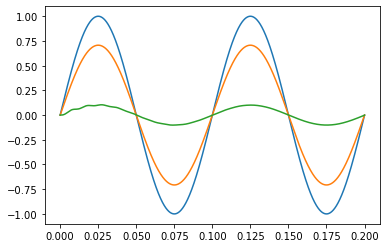

In [16]:
# SCIPY LFILTER
Q = 10
sf=int(31.25e4)
f0=100
total_time = 20/f0

f_in = 0.1*f0

t = np.linspace(0,total_time,int(total_time*sf))
x_in = np.sin(2*np.pi*f_in*t)


#LOWPASS
b,a  = iirfilter(1, f0/(sf/2), btype='low', ftype='butter')


omega_0 = 2 * np.pi * f0
num = np.array([omega_0**2])  # numerator: [omega_0^2]
den = np.array([1, omega_0 / Q, omega_0**2])*Q  # denominator: [1, 2 * zeta * omega_0, omega_0^2]
b, a = bilinear(num, den, sf)


omega_0 = 2 * np.pi * f0
num = np.array([0,omega_0,0])/Q*np.sqrt(2)  # numerator: [omega_0^2]
den = np.array([1, np.sqrt(2) * omega_0 /Q, omega_0**2])  # denominator: [1, 2 * zeta * omega_0, omega_0^2]
#b, a = bilinear(num, den, sf)

y = lfilter(b,a,x_in)

plt.plot(t,x_in)
plt.plot(t,x_in/np.sqrt(2))
plt.plot(t,y)

len(t), f0/(sf/2)

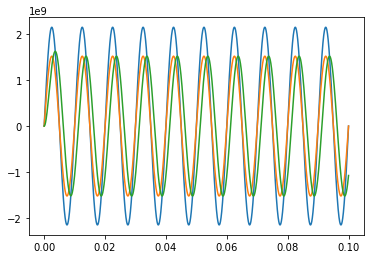

In [5]:
# DIGITAL FOR LOOP, NO PIPELINE

data_bit_depth = 32
coeff_bit_depth = 32

bitshift = 30


b,a  = iirfilter(1, f0/(sf/2), btype='low', ftype='butter')


b = np.round(b * (2**bitshift-1)).astype('int32')
a = np.round(a * (2**bitshift-1)).astype('int32')


x_in = (np.sin(2*np.pi*f0*t) * (2**(data_bit_depth - 1) - 1)).astype(np.int64)

acc = np.zeros_like(x_in, dtype = 'int64')

for n in range(len(x_in)):
    # Apply the filter difference equation
    acc[n] = sum(b[i] * x_in[n - i] if n - i >= 0 else 0 for i in range(len(b)))
    acc[n] -= sum(a[i] * acc[n - i] if n - i >= 0 else 0 for i in range(1, len(a)))
    acc[n] = acc[n]>>bitshift

y = np.clip(acc, -2**(data_bit_depth - 1), 2**(data_bit_depth - 1) - 1).astype(np.int32)


plt.plot(t,x_in)
plt.plot(t,x_in/np.sqrt(2))
plt.plot(t,y)


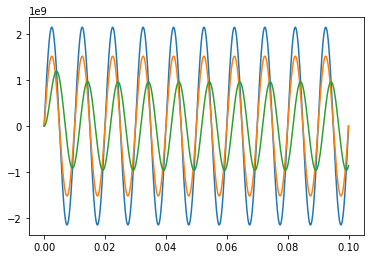

In [4]:
IN_DATA_WIDTH = 16
DATA_WIDTH = 32
COEFF_WIDTH = 32
ACC_WIDTH = DATA_WIDTH + COEFF_WIDTH
LOG_A0 = 30 


b,a  = iirfilter(1, f0/(sf/2), btype='low', ftype='butter')


b = np.round(b * (2**LOG_A0-1)).astype('int32')
a = np.round(a * (2**LOG_A0-1)).astype('int32')

b = np.pad(b, (0, 3 - len(b)), 'constant')
a = np.pad(a, (0, 3 - len(a)), 'constant')


iir_dict = {}
_, iir_dict['iir_a1'],iir_dict['iir_a2'] = a
iir_dict['iir_b0'], iir_dict['iir_b1'],iir_dict['iir_b2'] = b

a = [0, iir_dict['iir_a1'],iir_dict['iir_a2']]
b = [iir_dict['iir_b0'], iir_dict['iir_b1'],iir_dict['iir_b2']]

x_in = (np.sin(2*np.pi*f0*t) * (2**(IN_DATA_WIDTH - 1) - 1)).astype(np.int64)


x_4 = 0
x_3 = 0
x_2 = 0
x_1 = 0
x = 0
y_4 = 0
y_3 = 0
y_2 = 0
y_1 = 0
y = 0

b0_x = 0
b1_x1 = 0
b2_x2 = 0
b3_x3 = 0
b4_x4 = 0
a1_y1 = 0
a2_y2 = 0
a4_y4 = 0

y_out = []

test = []

for x_new in x_in:
    
    
    x_2 = x_1
    x_1 = x
    x = x_new << (DATA_WIDTH-IN_DATA_WIDTH)
    y_2 = y_1
    y_1 = y
    
    if (x|y) > 2**DATA_WIDTH: print('oops')
        
    
    
    y = (b0_x + b1_x1 + b2_x2 - a1_y1 - a2_y2) >> LOG_A0

    b0_x = b[0]*x   
    
    b1_x1 = b[1]*x_1
    b2_x2 = b[2]*x_2
    a1_y1 = a[1]*y_1
    a2_y2 = a[2]*y_2
    
    # Apply the filter difference equation
    #acc = b[0]*x + b[1]*x_1 + b[2]*x_2 - a[1]*y_1 - a[2]*y_2
  
    y_out.append(y)
    test.append(a1_y1)



plt.plot(t,x_in << (DATA_WIDTH-IN_DATA_WIDTH))
plt.plot(t,(x_in << (DATA_WIDTH-IN_DATA_WIDTH))/np.sqrt(2))
plt.plot(t,y_out)
#plt.plot(t,test)


#plt.axhline(2**31)

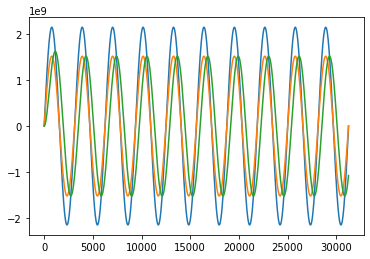

In [12]:
out = {
        'x': [],
        'y': []}

w00 = w0=w01=w1=y1=y=x1=0

for x_new in x_in:
    
    y = (b0x + w0) >> LOG_A0;
  
    b0x = b[0] * x
    a1y = a[1] * y
    b1x = b[1] * x
    a2y = a[2] * y
    b2x = b[2] * x

    
    w0 = b1x - a1y + w1;
    w1 = b2x - a2y;
    
    y = (b0x + w0) >> LOG_A0;
    w0 = b1x - a1y + w1;
    w1 = b2x - a2y;
    
    
    x = x1
    x = x_new << (DATA_WIDTH - IN_DATA_WIDTH)

    
    
    out['x'].append(x)
    out['y'].append(y)



plt.figure()
plt.plot(np.array(out['x']))
plt.plot(np.array(out['x'])/np.sqrt(2))
plt.plot(np.array(out['y']))




<ipython-input-27-3837fed98302>:15: RuntimeWarning: overflow encountered in scalar multiply
  b1_x1 = ( b[1] - b[0]*a[1] ) * x_1
<ipython-input-27-3837fed98302>:16: RuntimeWarning: overflow encountered in scalar multiply
  b2_x2 = ( b[2] + b[0]*a[2] - a[1]*b[1] ) * x_2


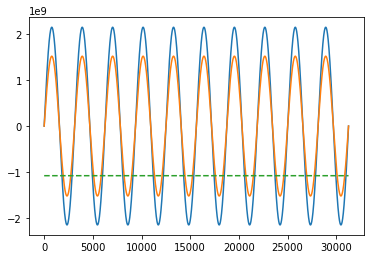

In [27]:
out = {
        'x': [],
        'y': []}


for x_new in x_in:
    
    
    y_4 = y_3 #4th fb delay
    y_3 = y_2 #3rd fb delay
    y_2 = y_1 #2nd fb delay
    y1 = (b0_x + b1_x1 + b2_x2 + b3_x3 + b4_x4 - a2_y2 - a4_y4) >> LOG_A0  #1st fb delay
    
    b0_x = b[0] * x
    b1_x1 = ( b[1] - b[0]*a[1] ) * x_1
    b2_x2 = ( b[2] + b[0]*a[2] - a[1]*b[1] ) * x_2
    b3_x3 = ( b[1]*a[2] - b[2]*a[1] ) * x_3
    b4_x4 = b[2]*a[2] * x_4
    
    a2_y2 = ( 2*a[2] - a[1]**2) * y_2
    a4_y4 = a[2]**2 * y_4
    
    x_4 = x_3
    x_3 = x_2
    x_2 = x_1
    x_1 = x
    x = x_new << (DATA_WIDTH - IN_DATA_WIDTH)

    
    
    out['x'].append(x)
    out['y'].append(y_1)



plt.figure()
plt.plot(np.array(out['x']))
plt.plot(np.array(out['x'])/np.sqrt(2))
plt.plot(np.array(out['y']),'--')




In [40]:
b[0],a[1], b[0]*a[1].astype('int64'), type(a[1])

(1078359, -1071585104, -1155553441164336, numpy.int32)

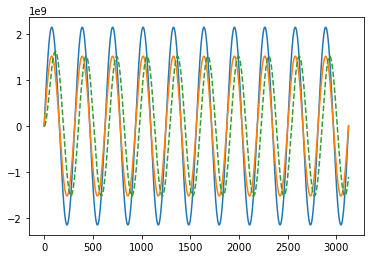

In [308]:
###TRANSPOSED DIRECT FORM 1

out = {
        'x': [],
        'y': []}

s1 = s1_old = s2 = s2_old = b0_x = b1_x = b2_x = a1_y = a2_y =0

for x0 in x_in:

    y = (b0_x + b2_x - a2_y + b1_x - a1_y) >> LOG_A0
     
    b0_x = b0_reg * x
    b1_x = b1_reg * x
    b2_x = b2_reg * x
    a1_y = a1_reg * y
    a2_y2 = a2_reg * y
    
        
    x = x0 << (DATA_WIDTH - IN_DATA_WIDTH)
   
    
    out['x'].append(x)
    out['y'].append(y)



plt.figure()
plt.plot(np.array(out['x']))
plt.plot(np.array(out['x'])/np.sqrt(2))
plt.plot(np.array(out['y']),'--')



In [125]:
#cutoff/nyq
### FIRST ORDER LOW PASS FILTER ###
iir_dict = {}
scale_factor = 2**30
sf = 1/(8e-9*4)
nyq = sf/2
b, a = butter(1, 1e-4, btype='low', analog=False)


### FIRST ORDER BAND PASS FILTER ###
iir_dict = {}
scale_factor = 2**30
sf = 1/(8e-9*4)
nyq = sf/2
f0 = 100000
Q = 100
w0 = 2 * np.pi * f0 / sf
alpha = np.sin(w0) / (2 * Q)
cos_w0 = np.cos(w0)
b  = np.array([alpha, 0, -alpha]) 
a = np.array([1 + alpha, -2 * cos_w0, 1 - alpha])

#b, a = iirfilter(1, [,2e-5+1e-5], btype='band', ftype='butter')




### JUST BASIC CHECK ###
b=np.array([1,0,0])
a=np.array([0,0,0])


#cutoff/nyq
### FIRST ORDER LOW PASS FILTER ###
iir_dict = {}
scale_factor = 2**30
sf = 1/(8e-9*4)/100
f0 = 1000
b, a = butter(1, f0/(sf/2), btype='low', analog=False)


print(a,b)

b = np.round(b * scale_factor).astype('int32')
a = np.round(a* scale_factor).astype('int32')

GAIN = 16

_, iir_dict['iir_a1'],iir_dict['iir_a2'] = np.pad(a, (0, 3 - len(a)), 'constant')
iir_dict['iir_b0'], iir_dict['iir_b1'],iir_dict['iir_b2'] = np.pad(b, (0, 3 - len(b)), 'constant')
iir_dict['gain'] = 2**GAIN


iir_dict, f0/(sf/2)

[ 1.         -0.98009326] [0.00995337 0.00995337]


({'iir_a1': -1052367125,
  'iir_a2': 0,
  'iir_b0': 10687349,
  'iir_b1': 10687349,
  'iir_b2': 0,
  'gain': 65536},
 0.006400000000000001)